In [1]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import random
import re
import matplotlib.pyplot as plt

In [2]:
# Importing the proteins data
ns5 = []
ns5d = []

f = open("../../../../../Data/Proteins/DENV1/NS5/DENV1_NS5.txt", "r")
for x in f:   
    if "DSS" in x:
        ns5d.append(1)
    elif "DHF" in x:
        ns5d.append(1)
    elif x[0] == ">":
        ns5d.append(0)
    else:
        x = x.replace("\n", "")
        ns5.append(x)

In [3]:
# Converting the array into DataFrames
ns5 = pd.DataFrame(ns5)

# Attaching the "Disease" label column to the input
ns5["Disease"] = ns5d

# Renaming the columns
ns5 = ns5.rename(index=str, columns={0: "Sequence", "Disease": "Disease"})

In [4]:
print("The combined shape of the given data is:", str(ns5.shape))
print("The length of the combined data is:", str(len(ns5.index)))
print("Does the combined data have any null value? ->", ns5.isnull().values.any())

ns5 = ns5.dropna(how = 'any',axis = 0) 

# Shuffling the data and then taking a peek
ns5 = ns5.sample(frac = 1)
print(ns5.head())

The combined shape of the given data is: (999, 2)
The length of the combined data is: 999
Does the combined data have any null value? -> False
                                              Sequence  Disease
410  GTGAQGETLGEKWKRQLNQLSKSEFNIYKRSGIMEVDRSEAKEGLK...        0
911  GTGAQGETLGEKWKRQLNQLSKSEFNIYKRSGIMEVDRSEAKEGLK...        1
84   GTGAQGETLGEKWKRQLNQLSKSEFNTYKRSGIMEVDRSEAKEGLK...        0
762  GTGAQGETLGEKWKRQLNQLSKSEFNTYKRSGIMEVDRSEAKEGLK...        1
686  GTGAQGETLGEKWKRQLNQLSKSEFNTYKRSGIMEVDRSEAKEGLK...        1


In [5]:
# Function to convert sequence strings into k-mer words, default size = 6 (hexamer words)
def getKmers(sequence, size = 6):
    return [sequence[x:x + size].lower() for x in range(len(sequence) - size + 1)]

ns5['words'] = ns5.apply(lambda x: getKmers(x['Sequence']), axis = 1)
ns5 = ns5.drop('Sequence', axis=1)

ns5_texts = list(ns5['words'])
for item in range(len(ns5_texts)):
    ns5_texts[item] = ' '.join(ns5_texts[item])

The shape of y is: (999,)


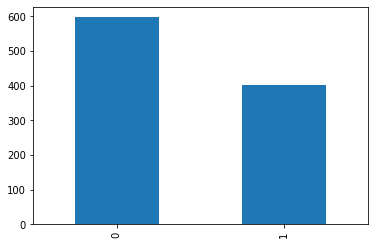

In [6]:
# Creating y and printing the shape of it
y = ns5.iloc[:, 0].values
print("The shape of y is:", y.shape)

# Checking the balance of the disease severity
ns5["Disease"].value_counts().sort_index().plot.bar()

In [7]:
# Creating the Bag of Words model using CountVectorizer()
# This is equivalent to k-mer counting
# The n-gram size of 4 was previously determined by testing
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(ngram_range = (4,4))
x = cv.fit_transform(ns5_texts)

# Print the shape of x
print("The shape of x matrix is:", x.shape)

The shape of x matrix is: (999, 4079)


In [8]:
# Splitting the human dataset into the training set and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 42)

# Printing the shapes of the train and test matrices
print("The shape of x_train is:", X_train.shape)
print("The shape of y_train is:", y_train.shape)
print("The shape of x_test is:", X_test.shape)
print("The shape of y_test is:", y_test.shape)

The shape of x_train is: (799, 4079)
The shape of y_train is: (799,)
The shape of x_test is: (200, 4079)
The shape of y_test is: (200,)


## Random Forest

In [9]:
# Fitting Random Forest Classification to the Training set
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

# Making a prediction of the test set sequences
y_pred = classifier.predict(X_test)

In [10]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

print("Confusion matrix\n")
print(pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred, name='Predicted')))

def get_metrics(y_test, y_predicted):
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted, average='weighted')
    recall = recall_score(y_test, y_predicted, average='weighted')
    f1 = f1_score(y_test, y_predicted, average='weighted')
    return accuracy, precision, recall, f1

print('')

accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
print("accuracy = {} \nprecision = {} \nrecall = {} \nf1 = {}".format(accuracy, precision, recall, f1))

Confusion matrix

Predicted   0   1
Actual           
0          93  27
1          47  33

accuracy = 0.63 
precision = 0.6185714285714285 
recall = 0.63 
f1 = 0.6178021978021978
